# Phishing Model Prototype

In [ ]:
%pip install numpy
%pip install pandas
%pip install joblib
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install scipy
%pip install jupyter
%pip install nltk
%pip install num2words
%pip install spacy
!python -m spacy download en_core_web_sm


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------------------ -------- 10.0/12.8 MB 52.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 50.2 MB/s  0:00:00
✔ Download and installation successful
You c

In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.cluster import HDBSCAN

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import num2words

import spacy
import sys
!{sys.executable} -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Data

In [21]:
data = "./data/Nazario_500.csv"

emails = pd.read_csv(data, sep=",", encoding="UTF-8")

df_emails = emails.copy()

df_emails.shape

(500, 6)

In [22]:
df_emails.sample(5)

,sender,receiver,date,subject,body,urls
382,Admin<>,jose@monkey.org,"Thu, 19 Apr 2018 13:43:06 +0800",FINAL WARNING!! {jose@monkey.org}Your mailbox ...,O60Y7D jose@monkey.org pBAN86X9ERA0b11P11v8...,1
385,PayPal Support Notification<Account@support.com>,jose@monkey.org,"Mon, 30 Jan 2017 20:01:26 -0500",Check Your Recent Activity By Logging in your ...,PayPal Secure Your account on the verge of ...,1
26,D1sc0ver C4rd. <sandra.zinkel@Vanderbilt.Edu>,you <sandra.zinkel@Vanderbilt.Edu>,"Tue, 28 Mar 2017 20:53:24 -0500",1 New Schedule Message.,"Dear Customer, We temporarily deactivated y...",1
453,DHL Express <sera.ko@dhl.com>,Recipients <sera.ko@dhl.com>,"Mon, 01 Oct 2018 04:23:45 -0700",DHL NOTIFICATION:- YOUR PACKAGE HAS ARRIVED,"Dear DHL Costomer, We recieved your pagekage ...",1
71,Notificados.com <notificacion@notificados.com>,jose@monkey.org,"Tue, 2 Feb 2021 06:25:48 +0200 (EET)",Envio de Burofax Online - ultima advertencia -...,Document Notificados www.notificad...,1


In [23]:
df_emails.dtypes

sender      object
receiver    object
date        object
subject     object
body        object
urls         int64
dtype: object

## 2. Data Understanding

In [24]:
df_emails.describe()

,urls
count,500.000000
mean,0.914000
std,0.280645
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### Emptyness

In [25]:
df_percentages = (100*df_emails.isna().sum()/len(df_emails)).to_frame()
df_percentages.sort_values(0, ascending = False)

,0
receiver,5.2
subject,0.4
sender,0.0
date,0.0
body,0.0
urls,0.0


### Duplicates

In [26]:
df_duplicated = df_emails.loc[df_emails.duplicated(keep=False)]
df_duplicated

,sender,receiver,date,subject,body,urls


## 3. Data Transformations

### Drop Empty & Duplicate

In [27]:
def drop_empty(dataframe):

    dataframe.dropna(inplace=True)

    return

drop_empty(df_emails)

df_emails.shape

(472, 6)

### Data Cleaning

In [28]:
def clean_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["date"] = df_emails["date"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)
    df_emails["body"] = df_emails["body"].apply(lambda x: x.encode("ascii", "ignore").decode() if isinstance(x, str) else x)

    return

def clean_upper_case(df_emails):
    df_emails["sender"] = df_emails["sender"].str.lower()
    df_emails["receiver"] = df_emails["receiver"].str.lower()
    df_emails["date"] = df_emails["date"].str.lower()
    df_emails["subject"] = df_emails["subject"].str.lower()
    df_emails["body"] = df_emails["body"].str.lower()

    return

def clean_punctuation(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'[.:,;-_¿?¡!"\'()\[\]{}\/%\$@+*\^]', '', x))

    return

def clean_numbers(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(r'\b\d+\b', lambda y: num2words.num2words(y.group(), lang='en'), x))

    return

def clena_stopwords(df_emails):
    stop_words = set(stopwords.words('english'))

    df_emails["sender"] = df_emails["sender"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["date"] = df_emails["date"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
    df_emails["body"] = df_emails["body"].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return

def clean_sidebar(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: x.replace("-", " "))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: x.replace("-", " "))
    df_emails["date"] = df_emails["date"].apply(lambda x: x.replace("-", " "))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: x.replace("-", " "))
    df_emails["body"] = df_emails["body"].apply(lambda x: x.replace("-", " "))

    return

numbers_post_ascii = r'[0123456789]'

def clean_numbers_post_ascii(df_emails):
    df_emails["sender"] = df_emails["sender"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["receiver"] = df_emails["receiver"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["date"] = df_emails["date"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["subject"] = df_emails["subject"].apply(lambda x: re.sub(numbers_post_ascii, '', x))
    df_emails["body"] = df_emails["body"].apply(lambda x: re.sub(numbers_post_ascii, '', x))

    return


In [29]:
def clean_text(df_emails):

    clean_ascii(df_emails)
    clean_upper_case(df_emails)
    clean_punctuation(df_emails)
    clean_numbers(df_emails)
    clena_stopwords(df_emails)
    clean_sidebar(df_emails)
    clean_numbers_post_ascii(df_emails)

    return

clean_text(df_emails)
print(df_emails)

                                              sender  \
0    email administrator upgradesupportemarketingcom   
1               customer apple customer applehkbnnet   
2                     onedrive infoanalyticstresscom   
3                       monkeyorg kokushikyodonewsjp   
4               rivers shareece r srriversemailscedu   
..                                               ...   
495                            monkeyorg ucbqlobecom   
496                 dhl express trademahceramtilecom   
497       avast antivirus opskpaintralineshippingcom   
498                            itunes officialailcom   
499                 server notificationchairnmfllorg   

                                   receiver  \
0    recipients upgradesupportemarketingcom   
1                             josemonkeyorg   
2                             josemonkeyorg   
3                             josemonkeyorg   
4             careergmailcom careergmailcom   
..                                      ...  

### Bag Of Words

In [30]:
def tokenize_text(df_emails):

    df_emails["sender_T"] = df_emails["sender"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["receiver_T"] = df_emails["receiver"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["date_T"] = df_emails["date"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["subject_T"] = df_emails["subject"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])
    df_emails["body_T"] = df_emails["body"].apply(lambda x: [token.text for token in nlp(x) if not token.is_space])

    return

In [31]:
vectorizer = CountVectorizer()

def vectorize_tokens(df_emails):

    email_plain_text = df_emails['sender_T'].astype('str') + ""  + df_emails['receiver_T'].astype('str') + " " + df_emails['date_T'].astype('str') + " " + df_emails['subject_T'].astype('str') + " " + df_emails['body_T'].astype('str')

    df_vectorized = vectorizer.fit_transform(email_plain_text)

    return df_vectorized

In [32]:
def prepare_text(df_emails):

    tokenize_text(df_emails)
    X = vectorize_tokens(df_emails)

    return X

In [33]:
X = prepare_text(df_emails)

print(X)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 29442 stored elements and shape (472, 5931)>
  Coords	Values
  (0, 1688)	2
  (0, 151)	1
  (0, 5521)	2
  (0, 4301)	1
  (0, 5066)	1
  (0, 3467)	1
  (0, 3149)	1
  (0, 5410)	4
  (0, 5257)	3
  (0, 4780)	2
  (0, 3468)	1
  (0, 4779)	1
  (0, 2438)	2
  (0, 1974)	1
  (0, 3655)	1
  (0, 246)	1
  (0, 5598)	1
  (0, 4185)	1
  (0, 3087)	2
  (0, 235)	2
  (0, 699)	1
  (0, 76)	1
  (0, 520)	1
  (0, 1297)	1
  (0, 1931)	1
  :	:
  (471, 3238)	1
  (471, 4501)	1
  (471, 4094)	1
  (471, 4729)	1
  (471, 4281)	1
  (471, 5570)	1
  (471, 3442)	1
  (471, 3177)	1
  (471, 4455)	1
  (471, 4675)	1
  (471, 3129)	1
  (471, 4287)	1
  (471, 4774)	1
  (471, 3147)	1
  (471, 1706)	1
  (471, 5534)	1
  (471, 713)	1
  (471, 5514)	1
  (471, 4634)	1
  (471, 1650)	1
  (471, 3544)	1
  (471, 3947)	1
  (471, 1908)	1
  (471, 2640)	1
  (471, 2801)	1


## 4. Unsupervised Model

In [34]:
kmeans_clusters = KMeans(n_clusters=2)
kmeans_clusters.fit(X)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [35]:
labels = kmeans_clusters.labels_
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


<Axes: xlabel='Cluster_KMeans'>

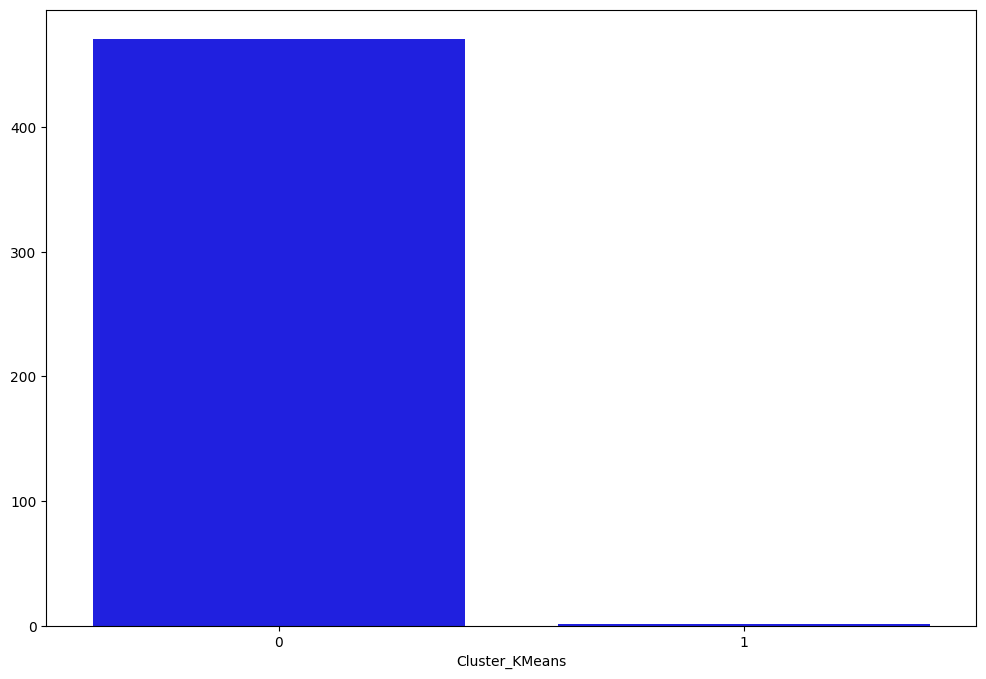

In [36]:
df_kmeans = df_emails.copy()
df_kmeans["Cluster_KMeans"] = labels

cluster_distrib_kmeans = df_kmeans["Cluster_KMeans"].value_counts()

fig=plt.figure(figsize=(12,8))
sns.barplot(x=cluster_distrib_kmeans.index, y=cluster_distrib_kmeans.values, color='b')

## 5. Graphical Visualization

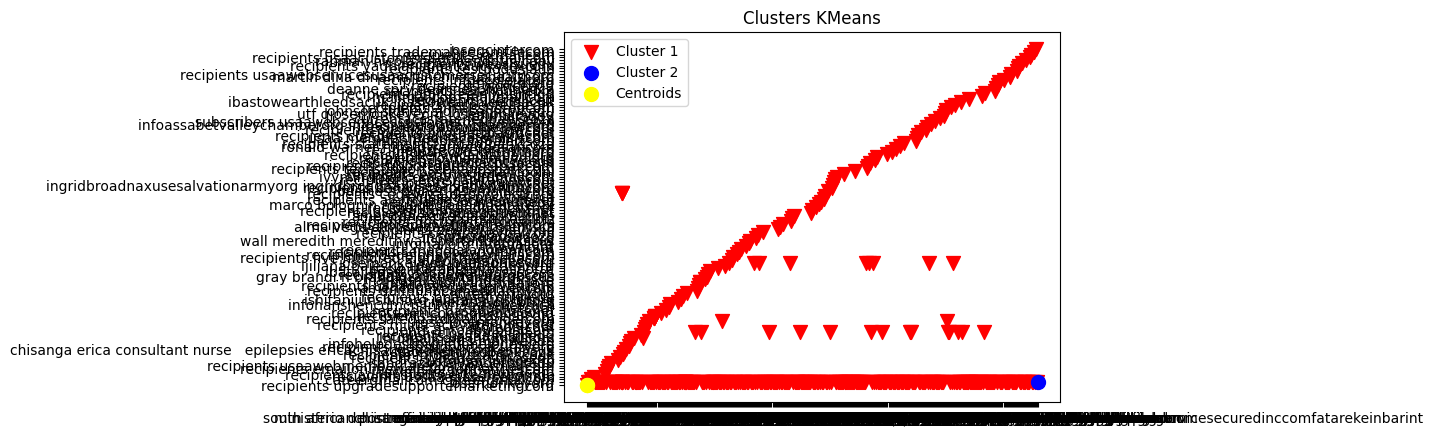

In [37]:
col = df_kmeans.to_numpy()

plt.scatter(col[kmeans_clusters.labels_ == 0, 0], col[kmeans_clusters.labels_ == 0, 1], s = 100, marker='v', c = 'red', label = 'Cluster 1')
plt.scatter(col[kmeans_clusters.labels_ == 1, 0], col[kmeans_clusters.labels_ == 1, 1], s = 100, marker='o', c = 'blue', label = 'Cluster 2')

plt.scatter(kmeans_clusters.cluster_centers_[:, 0], kmeans_clusters.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters KMeans')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

cluster_labels = np.unique(df_kmeans["Cluster_KMeans"])

n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(df_kmeans, kmeans_clusters.labels_, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[labels == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red",
            linestyle="--")
plt.yticks(yticks, cluster_labels+1)
plt.title("Siluetas")
plt.show()

ValueError: could not convert string to float: 'email administrator upgradesupportemarketingcom'

In [ ]:
inertia = []
df_kmeans = df_emails.copy()
for i in range(1, 15):
    km = KMeans(n_clusters=i)
    km.fit(df_kmeans)
    inertia.append(km.inertia_)

plt.plot(range(1,15), inertia, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Inertia")
plt.show()

In [ ]:
silhouette = []
for i in range(2, 10):
    km = KMeans(n_clusters=i)
    km.fit(df_kmeans)
    silhouette.append(silhouette_score(df_kmeans, km.labels_))

plt.plot(range(2,10), silhouette, marker='o')
plt.xlabel("Number Groups")
plt.ylabel("Silhouette")
plt.show()